# Training Notebook for Transformer with Classifier Free Guidance
To be run using on the Google Colab servers

### Global setup

In [1]:
import os
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from time import strftime

# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Connect to Github repository and import code

In [2]:
# RUN THIS ONCE AT THE START OF THE SESSION
# clone github repository
!rm -rf /content/VQ-VAE-Tranformer-Image-Gen
!git clone --single-branch --branch modern https://github.com/patrickmastorga/VQ-VAE-Tranformer-Image-Gen.git

# add repo to sys path to allow imports
import sys
sys.path.append('/content/VQ-VAE-Tranformer-Image-Gen')

Cloning into 'VQ-VAE-Tranformer-Image-Gen'...
remote: Enumerating objects: 385, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 385 (delta 68), reused 72 (delta 63), pack-reused 286 (from 2)
Receiving objects: 100% (385/385), 184.83 MiB | 43.14 MiB/s, done.
Resolving deltas: 100% (188/188), done.


In [3]:
# RUN THIS AT THE START AS WELL AS EVERY TIME THE REPO IS UPDATED
# pull changes from github
%cd /content/VQ-VAE-Tranformer-Image-Gen
!git pull origin modern

# refrsh the imports
from importlib import reload
import TF.model
reload(TF.model)
import TF.model_cfg
reload(TF.model_cfg)
import VQ.model_ivo
reload(VQ.model_ivo)

from VQ.model_ivo import Encoder, Decoder, Quantizer, VQ_VAE, LATENT_W, LATENT_H, NUM_EMBEDDINGS
from TF.model_cfg import CFGTransformerPrior, VOCAB_SIZE, SEQ_LEN, BOS_ID

assert VOCAB_SIZE == NUM_EMBEDDINGS
assert SEQ_LEN == LATENT_H * LATENT_W

/content/VQ-VAE-Tranformer-Image-Gen
From https://github.com/patrickmastorga/VQ-VAE-Tranformer-Image-Gen
 * branch            modern     -> FETCH_HEAD
Already up to date.


### Load pretrained Decoder and CelebA embeddings

Loading dataset...
Loading VQ-VAE model...


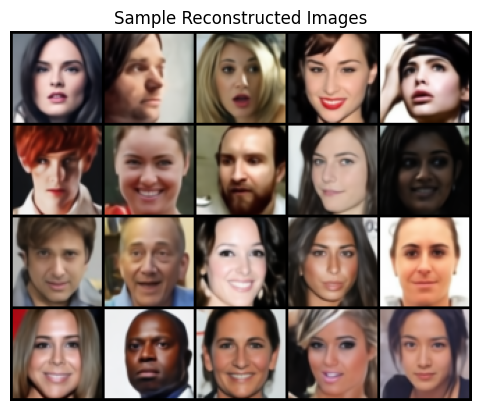

In [4]:
INDICES_PATH = '/content/drive/MyDrive/vq_models/celeba_indices_uint16_ivo.pt'
ATTRS_PATH = '/content/drive/MyDrive/vq_models/celeba_attrs_uint16_ivo.pt'
CHECKPOINT_PATH = '/content/drive/MyDrive/vq_models/checkpoint_ivo_new.pt'

# load CelebA embeddings dataset
print('Loading dataset...')
celeba_embeddings = torch.utils.data.TensorDataset(torch.load(INDICES_PATH), torch.load(ATTRS_PATH))

# load VQ-VAE model parameters
print('Loading VQ-VAE model...')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder = Encoder()
decoder = Decoder()
quantizer = Quantizer(use_EMA=True)
vq_vae = VQ_VAE(encoder, decoder, quantizer, use_EMA=True).to(device)
vq_vae.eval()

checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
vq_vae.load_state_dict(checkpoint['model_state'])

# visualize
grid_x = 5
grid_y = 4

samples = torch.stack([celeba_embeddings[i][0] for i in range(grid_x * grid_y)]).long().to(device)
images = vq_vae.reconstruct_from_indices(samples.view(-1, LATENT_W, LATENT_H))
img = torchvision.utils.make_grid(images, grid_x, normalize=True, value_range=(0, 1))

plt.title(f'Sample Reconstructed Images')
plt.axis('off')
plt.imshow(img.permute(1,2,0).cpu())

### Initialize Model and dataloader

In [5]:
BATCH_SIZE = 256

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataloader = torch.utils.data.DataLoader(celeba_embeddings, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
model = CFGTransformerPrior().to(device)

### Train model

Checkpoint loaded. Resuming from training step 19840.
15:16:08 Begin Training
15:16:22 TRAINING Step [19900/35680]; Loss: 4.632510
15:16:45 TRAINING Step [20000/35680]; Loss: 4.632603
15:16:45 Checkpoint saved at step 20000 to /content/drive/MyDrive/tf_models/tf16_cfg_20000.pt


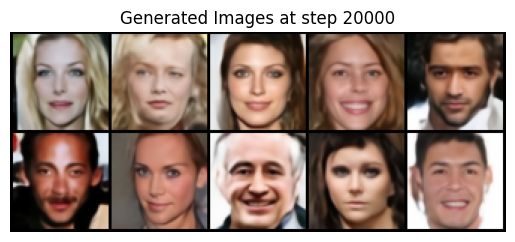

15:17:11 TRAINING Step [20100/35680]; Loss: 4.635730
15:17:33 TRAINING Step [20200/35680]; Loss: 4.636538
15:17:56 TRAINING Step [20300/35680]; Loss: 4.633321
15:18:19 TRAINING Step [20400/35680]; Loss: 4.631952
15:18:42 TRAINING Step [20500/35680]; Loss: 4.640251
15:19:05 TRAINING Step [20600/35680]; Loss: 4.633679
15:19:28 TRAINING Step [20700/35680]; Loss: 4.628790
15:19:50 TRAINING Step [20800/35680]; Loss: 4.626170
15:20:13 TRAINING Step [20900/35680]; Loss: 4.631559
15:20:36 TRAINING Step [21000/35680]; Loss: 4.630014
15:20:36 Checkpoint saved at step 21000 to /content/drive/MyDrive/tf_models/tf16_cfg_21000.pt


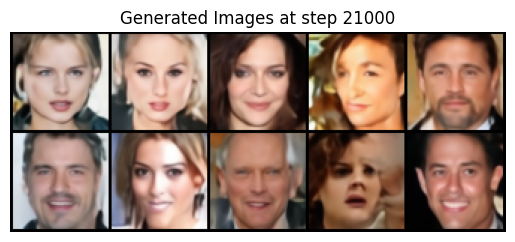

15:21:01 TRAINING Step [21100/35680]; Loss: 4.630837
15:21:24 TRAINING Step [21200/35680]; Loss: 4.632449
15:21:47 TRAINING Step [21300/35680]; Loss: 4.628025
15:22:10 TRAINING Step [21400/35680]; Loss: 4.628371
15:22:33 TRAINING Step [21500/35680]; Loss: 4.622732
15:22:55 TRAINING Step [21600/35680]; Loss: 4.625197
15:23:18 TRAINING Step [21700/35680]; Loss: 4.624758
15:23:41 TRAINING Step [21800/35680]; Loss: 4.627719
15:24:04 TRAINING Step [21900/35680]; Loss: 4.624148
15:24:27 TRAINING Step [22000/35680]; Loss: 4.625072
15:24:27 Checkpoint saved at step 22000 to /content/drive/MyDrive/tf_models/tf16_cfg_22000.pt


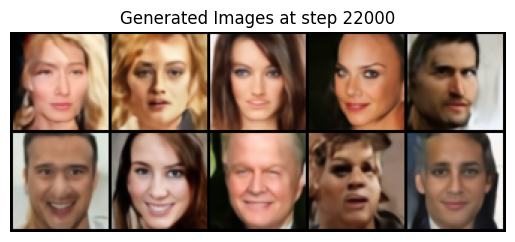

15:24:52 TRAINING Step [22100/35680]; Loss: 4.625262
15:25:15 TRAINING Step [22200/35680]; Loss: 4.622606
15:25:38 TRAINING Step [22300/35680]; Loss: 4.619775
15:26:01 TRAINING Step [22400/35680]; Loss: 4.613860
15:26:23 TRAINING Step [22500/35680]; Loss: 4.619348
15:26:46 TRAINING Step [22600/35680]; Loss: 4.623269
15:27:09 TRAINING Step [22700/35680]; Loss: 4.615419
15:27:32 TRAINING Step [22800/35680]; Loss: 4.626084
15:27:55 TRAINING Step [22900/35680]; Loss: 4.621787
15:28:18 TRAINING Step [23000/35680]; Loss: 4.618558
15:28:18 Checkpoint saved at step 23000 to /content/drive/MyDrive/tf_models/tf16_cfg_23000.pt


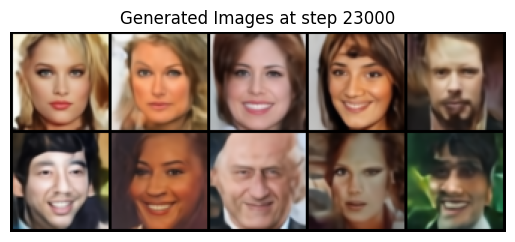

15:28:43 TRAINING Step [23100/35680]; Loss: 4.613097
15:29:06 TRAINING Step [23200/35680]; Loss: 4.611252
15:29:29 TRAINING Step [23300/35680]; Loss: 4.618240
15:29:51 TRAINING Step [23400/35680]; Loss: 4.615959
15:30:14 TRAINING Step [23500/35680]; Loss: 4.615391
15:30:37 TRAINING Step [23600/35680]; Loss: 4.617641
15:31:00 TRAINING Step [23700/35680]; Loss: 4.618035
15:31:23 TRAINING Step [23800/35680]; Loss: 4.617091
15:31:46 TRAINING Step [23900/35680]; Loss: 4.608858
15:32:08 TRAINING Step [24000/35680]; Loss: 4.613529
15:32:09 Checkpoint saved at step 24000 to /content/drive/MyDrive/tf_models/tf16_cfg_24000.pt


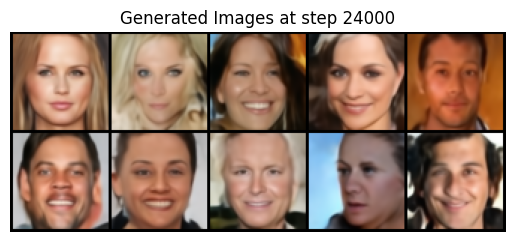

15:32:34 TRAINING Step [24100/35680]; Loss: 4.611314
15:32:56 TRAINING Step [24200/35680]; Loss: 4.611654
15:33:19 TRAINING Step [24300/35680]; Loss: 4.612504
15:33:42 TRAINING Step [24400/35680]; Loss: 4.611626
15:34:05 TRAINING Step [24500/35680]; Loss: 4.610621
15:34:28 TRAINING Step [24600/35680]; Loss: 4.610803
15:34:51 TRAINING Step [24700/35680]; Loss: 4.606242
15:35:14 TRAINING Step [24800/35680]; Loss: 4.603374
15:35:36 TRAINING Step [24900/35680]; Loss: 4.605670
15:35:59 TRAINING Step [25000/35680]; Loss: 4.605789
15:35:59 Checkpoint saved at step 25000 to /content/drive/MyDrive/tf_models/tf16_cfg_25000.pt


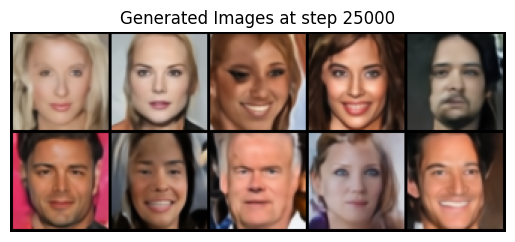

15:36:24 TRAINING Step [25100/35680]; Loss: 4.610689
15:36:47 TRAINING Step [25200/35680]; Loss: 4.612450
15:37:10 TRAINING Step [25300/35680]; Loss: 4.606776
15:37:33 TRAINING Step [25400/35680]; Loss: 4.609209
15:37:56 TRAINING Step [25500/35680]; Loss: 4.602117
15:38:19 TRAINING Step [25600/35680]; Loss: 4.606042
15:38:42 TRAINING Step [25700/35680]; Loss: 4.602925
15:39:05 TRAINING Step [25800/35680]; Loss: 4.605359
15:39:27 TRAINING Step [25900/35680]; Loss: 4.603079
15:39:50 TRAINING Step [26000/35680]; Loss: 4.601532
15:39:51 Checkpoint saved at step 26000 to /content/drive/MyDrive/tf_models/tf16_cfg_26000.pt


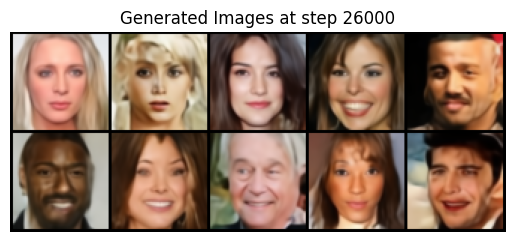

15:40:16 TRAINING Step [26100/35680]; Loss: 4.604887
15:40:38 TRAINING Step [26200/35680]; Loss: 4.603046
15:41:01 TRAINING Step [26300/35680]; Loss: 4.597860
15:41:24 TRAINING Step [26400/35680]; Loss: 4.599386
15:41:47 TRAINING Step [26500/35680]; Loss: 4.595790
15:42:10 TRAINING Step [26600/35680]; Loss: 4.601201
15:42:33 TRAINING Step [26700/35680]; Loss: 4.599439
15:42:56 TRAINING Step [26800/35680]; Loss: 4.601457
15:43:19 TRAINING Step [26900/35680]; Loss: 4.602076
15:43:42 TRAINING Step [27000/35680]; Loss: 4.599743
15:43:42 Checkpoint saved at step 27000 to /content/drive/MyDrive/tf_models/tf16_cfg_27000.pt


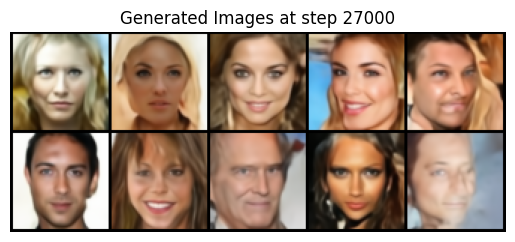

15:44:07 TRAINING Step [27100/35680]; Loss: 4.598098
15:44:30 TRAINING Step [27200/35680]; Loss: 4.595659
15:44:53 TRAINING Step [27300/35680]; Loss: 4.596526
15:45:15 TRAINING Step [27400/35680]; Loss: 4.593035
15:45:38 TRAINING Step [27500/35680]; Loss: 4.596889
15:46:01 TRAINING Step [27600/35680]; Loss: 4.595839
15:46:24 TRAINING Step [27700/35680]; Loss: 4.595048
15:46:47 TRAINING Step [27800/35680]; Loss: 4.600026
15:47:10 TRAINING Step [27900/35680]; Loss: 4.591846
15:47:33 TRAINING Step [28000/35680]; Loss: 4.590473
15:47:33 Checkpoint saved at step 28000 to /content/drive/MyDrive/tf_models/tf16_cfg_28000.pt


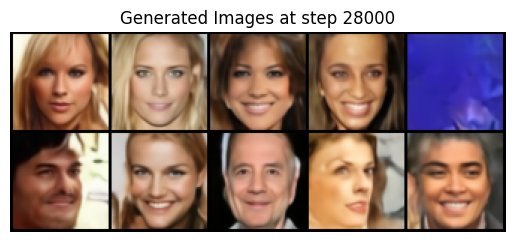

15:47:58 TRAINING Step [28100/35680]; Loss: 4.592098
15:48:21 TRAINING Step [28200/35680]; Loss: 4.593488
15:48:44 TRAINING Step [28300/35680]; Loss: 4.594822
15:49:07 TRAINING Step [28400/35680]; Loss: 4.592142
15:49:29 TRAINING Step [28500/35680]; Loss: 4.597483
15:49:52 TRAINING Step [28600/35680]; Loss: 4.590835
15:50:15 TRAINING Step [28700/35680]; Loss: 4.587411
15:50:38 TRAINING Step [28800/35680]; Loss: 4.592287
15:51:01 TRAINING Step [28900/35680]; Loss: 4.585499
15:51:24 TRAINING Step [29000/35680]; Loss: 4.588694
15:51:24 Checkpoint saved at step 29000 to /content/drive/MyDrive/tf_models/tf16_cfg_29000.pt


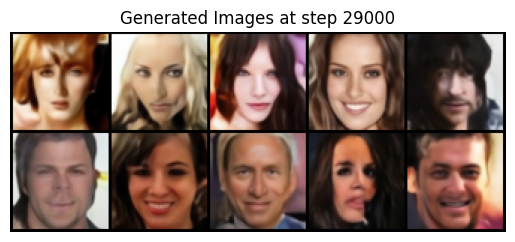

15:51:49 TRAINING Step [29100/35680]; Loss: 4.592766
15:52:12 TRAINING Step [29200/35680]; Loss: 4.591085
15:52:35 TRAINING Step [29300/35680]; Loss: 4.591869
15:52:58 TRAINING Step [29400/35680]; Loss: 4.583978
15:53:21 TRAINING Step [29500/35680]; Loss: 4.588892
15:53:44 TRAINING Step [29600/35680]; Loss: 4.585637
15:54:07 TRAINING Step [29700/35680]; Loss: 4.588055
15:54:29 TRAINING Step [29800/35680]; Loss: 4.587292
15:54:52 TRAINING Step [29900/35680]; Loss: 4.586200
15:55:15 TRAINING Step [30000/35680]; Loss: 4.587035
15:55:15 Checkpoint saved at step 30000 to /content/drive/MyDrive/tf_models/tf16_cfg_30000.pt


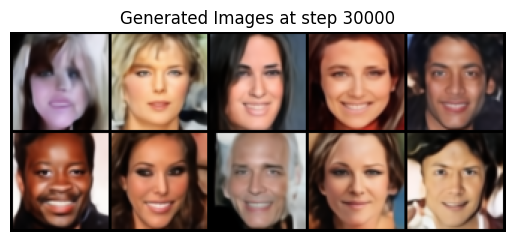

15:55:40 TRAINING Step [30100/35680]; Loss: 4.589622
15:56:03 TRAINING Step [30200/35680]; Loss: 4.581033
15:56:26 TRAINING Step [30300/35680]; Loss: 4.583413
15:56:49 TRAINING Step [30400/35680]; Loss: 4.582940
15:57:12 TRAINING Step [30500/35680]; Loss: 4.586704
15:57:35 TRAINING Step [30600/35680]; Loss: 4.586477
15:57:58 TRAINING Step [30700/35680]; Loss: 4.578847
15:58:21 TRAINING Step [30800/35680]; Loss: 4.581304
15:58:44 TRAINING Step [30900/35680]; Loss: 4.586184
15:59:07 TRAINING Step [31000/35680]; Loss: 4.582077
15:59:07 Checkpoint saved at step 31000 to /content/drive/MyDrive/tf_models/tf16_cfg_31000.pt


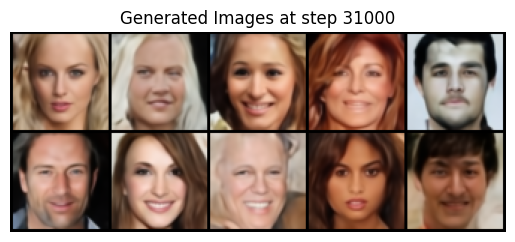

15:59:32 TRAINING Step [31100/35680]; Loss: 4.581007
15:59:55 TRAINING Step [31200/35680]; Loss: 4.580287
16:00:18 TRAINING Step [31300/35680]; Loss: 4.581642
16:00:41 TRAINING Step [31400/35680]; Loss: 4.580300
16:01:03 TRAINING Step [31500/35680]; Loss: 4.580945
16:01:26 TRAINING Step [31600/35680]; Loss: 4.583565
16:01:49 TRAINING Step [31700/35680]; Loss: 4.577686
16:02:12 TRAINING Step [31800/35680]; Loss: 4.573434
16:02:35 TRAINING Step [31900/35680]; Loss: 4.577796
16:02:58 TRAINING Step [32000/35680]; Loss: 4.579067
16:02:58 Checkpoint saved at step 32000 to /content/drive/MyDrive/tf_models/tf16_cfg_32000.pt


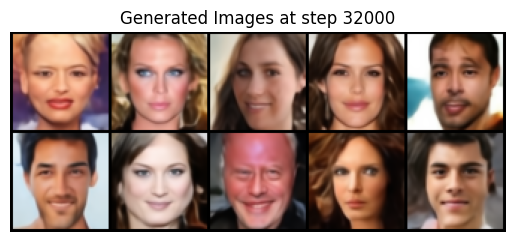

16:03:23 TRAINING Step [32100/35680]; Loss: 4.576393
16:03:46 TRAINING Step [32200/35680]; Loss: 4.576922
16:04:09 TRAINING Step [32300/35680]; Loss: 4.580494
16:04:32 TRAINING Step [32400/35680]; Loss: 4.578865
16:04:55 TRAINING Step [32500/35680]; Loss: 4.577305
16:05:18 TRAINING Step [32600/35680]; Loss: 4.573456


In [ ]:
# training hyperparameters
EPOCHS = 20
LEARNING_RATE = 8e-4
LOG_INTERVAL = 100
SAVE_INTERVAL = 1000
SAVE_PATH = '/content/drive/MyDrive/tf_models/tf16_cfg' # THE SUFFIX '_{training_step}.pt' will be appended

# model hyperparameters
P_MASK = 0.15

# optionally, resume training from a checkpoint
CONTINUE_FROM_CHECKPOINT = True #  # str | None
CHECKPOINT_PATH = '/content/drive/MyDrive/tf_models/tf16_cfg_19840.pt'

# optmizer and training state vars
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
train_state = {
    'losses': [],
    'logging_steps': [],
    'running_loss': 0.0,
    'steps': 0
}

# load from checkpoint
if CONTINUE_FROM_CHECKPOINT:
    train_state = torch.load(CHECKPOINT_PATH, map_location=device)
    model.load_state_dict(train_state['model_state'])
    optimizer.load_state_dict(train_state['optmiizer_state'])
    print(f'Checkpoint loaded. Resuming from training step {train_state['steps']}.')

# attributes for sampling reconstructions
_, sample_attrs = next(iter(dataloader))
sample_attrs = sample_attrs.to(device).long()

# training loop
print(f'{strftime('%H:%M:%S')} Begin Training')
end_step = train_state['steps'] + len(dataloader) * EPOCHS
model.train()
for epoch in range(EPOCHS):
    for batch_idx, batch in enumerate(dataloader):
        # training step
        targets, attrs = batch
        targets = targets.to(device).long()
        attrs = attrs.to(device).long()

        inputs = torch.empty_like(targets)
        inputs[:, 0] = BOS_ID
        inputs[:, 1:] = targets[:, :-1]

        # mask attributes at random
        mask_attr = torch.rand(attrs.shape[0], device=attrs.device) < P_MASK
        attrs[mask_attr] = 2

        logits = model(inputs, attrs)
        loss = nn.functional.cross_entropy(
            logits.view(-1, VOCAB_SIZE),
            targets.view(-1)
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_state['steps'] += 1
        train_state['running_loss'] += loss.item()

        # logging step
        if train_state['steps'] % LOG_INTERVAL == 0:
            avg_loss = train_state['running_loss'] / LOG_INTERVAL
            train_state['running_loss'] = 0.0
            train_state['losses'].append(avg_loss)
            print(f'{strftime('%H:%M:%S')} TRAINING Step [{train_state['steps']}/{end_step}]; Loss: {avg_loss:.6f}')

        # saving step
        if train_state['steps'] % SAVE_INTERVAL == 0 or (epoch == EPOCHS - 1 and batch_idx == len(dataloader) - 1):
            train_state['model_state'] = model.state_dict()
            train_state['optmiizer_state'] = optimizer.state_dict()
            model_save_path = f'{SAVE_PATH}_{train_state['steps']}.pt'
            torch.save(train_state, model_save_path)
            print(f'{strftime('%H:%M:%S')} Checkpoint saved at step {train_state['steps']} to {model_save_path}')

            # visualize unconditional reconstructions
            grid_x = 5
            grid_y = 2

            model.eval()
            samples = model.generate(grid_x * grid_y, sample_attrs[:grid_x * grid_y])
            model.train()

            images = vq_vae.reconstruct_from_indices(samples.view(-1, LATENT_W, LATENT_H))
            img = torchvision.utils.make_grid(images, grid_x, normalize=True, value_range=(0, 1))

            plt.title(f'Generated Images at step {train_state['steps']}')
            plt.axis('off')
            plt.imshow(img.permute(1,2,0).cpu())
            plt.show()

print(f'Training complete.')

train_state['logging_steps'] = [i * 100 for i in range(198)]
torch.save(train_state, CHECKPOINT_PATH)

# Prepare reconstructions
grid_x = 5
grid_y = 4

model.eval()
samples = model.generate(grid_x * grid_y, sample_attrs[:grid_x * grid_y])

images = vq_vae.reconstruct_from_indices(samples.view(-1, LATENT_W, LATENT_H))
img = torchvision.utils.make_grid(images, grid_x, normalize=True, value_range=(0, 1))

# Side-by-side plot
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Loss curves
axes[0].plot(train_state['logging_steps'], train_state['losses'])

axes[0].set_xlabel('Training Step')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss over Training Steps')
axes[0].grid(True)

# Reconstructions
axes[1].imshow(img.permute(1, 2, 0).cpu())
axes[1].set_title('Generated Images')
axes[1].axis('off')

plt.tight_layout()
plt.show()